# Fractal Market Memory
--This is where the explanation will go--

In [237]:
### IMPORTS

# Standard library
from datetime import datetime
import warnings

# Third-party libraries
# >> python -m pip install -U --extra-index-url https://download.pytorch.org/whl/cpu numpy pandas requests matplotlib scipy scikit-learn arch statsmodels torch

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import torch
from scipy.stats import genpareto, kurtosis
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Local modules
from ARCHIVE.V1.V1_secret import API_TOKEN

# Config
warnings.filterwarnings("ignore", category=ConvergenceWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [238]:
### LOGGING

import json, time, logging

class Config:
    LOG_DIR = "logs"
    SCR_DIR = "screenshots"

class JsonFormatter(logging.Formatter):
    """
    True JSON formatter: includes ISO-8601 timestamp, source, and supports exceptions.
    """
    def format(self, record: logging.LogRecord) -> str:
        base = {
            "time": self.formatTime(record),
            "level": record.levelname,
            "logger": record.name,
            "module": record.module,
            "func": record.funcName,
            "line": record.lineno,
            "message": record.getMessage(),
        }
        if record.exc_info:
            base["exc_info"] = self.formatException(record.exc_info)
        return json.dumps(base, ensure_ascii=False)

    def formatTime(self, record, datefmt=None):
        # ISO-8601 with milliseconds
        t = self.converter(record.created) if hasattr(self, "converter") else time.localtime(record.created)
        s = time.strftime("%Y-%m-%dT%H:%M:%S", t)
        return f"{s}.{int(record.msecs):03d}"

class Logger:
    """
    Structured JSON logging to console (INFO) + rotating file (DEBUG).
    Idempotent: calling setup() multiple times will not add duplicate handlers.
    """
    @staticmethod
    def setup(name: str = "fractal",
              log_dir: str = Config.LOG_DIR,
              max_bytes: int = 5_000_000,
              backups: int = 3,
              console_level: int = logging.INFO,
              file_level: int = logging.DEBUG) -> logging.Logger:

        logger = logging.getLogger(name)
        logger.setLevel(logging.DEBUG)
        logger.propagate = False  # avoid double logs via root

        # If already configured, return as-is
        if getattr(logger, "_fractal_configured", False):
            return logger

        fmt = JsonFormatter()

        # Console handler
        ch = logging.StreamHandler()
        ch.setLevel(console_level)
        ch.setFormatter(fmt)
        logger.addHandler(ch)

        logger._fractal_configured = True
        return logger

def log_method(fn):
    """
    Decorator: logs entry/exit + elapsed time; captures exceptions with traceback.
    Assumes 'self.logger' exists; otherwise falls back to 'fractal' logger.
    """
    import functools, time as _time
    @functools.wraps(fn)
    def wrapper(self, *args, **kwargs):
        logger = getattr(self, "logger", logging.getLogger("fractal"))
        name = f"{self.__class__.__name__}.{fn.__name__}"
        logger.info(f"▶ Starting {name}")
        start = _time.time()
        try:
            result = fn(self, *args, **kwargs)
            elapsed = _time.time() - start
            logger.info(f"✔ Finished {name} in {elapsed:.2f}s")
            return result
        except Exception:
            elapsed = _time.time() - start
            logger.exception(f"✖ Error in {name} after {elapsed:.2f}s")
            raise
    return wrapper


In [239]:
### DATA COLLECTION AND PLOTTING

# data collection
def get_daily_data(symbol, start_date, end_date, api_token, logger):
    """
    Fetch end‑of‑day price and volume for a given symbol from the EODHD API.
    Returns a DataFrame indexed by business‑day datetime with ‘close’ and ‘volume’ columns, or an empty DataFrame on failure.
    """
    logger.info(f"Fetching data for {symbol} from {start_date} to {end_date}")
    url  = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    resp = requests.get(url)
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())
        if 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
            df = df.set_index('datetime').asfreq('B').rename_axis(None)
            return df[['close', 'volume']]
    logger.warning(f"No data for {symbol}")
    return pd.DataFrame()

# data cleaning
def clean_data(data):
    logger.info(f"Cleaning data for {data.shape[0]} rows")
    # Ensure DatetimeIndex, sorted, unique
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data = data[~data.index.duplicated(keep='last')]
    # regularize to business days if your downstream requires it
    data = data.asfreq('B', method='pad')
    # Attach freq only if pandas can infer it
    inferred = pd.infer_freq(data.index)
    if inferred:
        data.index.freq = inferred
    # Fill residual NaNs; consider dropping bfill if backward fill is undesirable
    data = data.ffill().bfill()

    return data

# plotting
def plot_with_quantification(data, title):
    """
    Fit and plot a linear trend on the price series, then overlay ±1 σ and ±2 σ bands on the residuals.
    Highlights points outside ±1 σ and shows a Matplotlib figure annotated with mean and residual standard deviation.
    """
    df = data.copy().reset_index().rename(columns={'index':'datetime'})
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    model = LinearRegression().fit(X, y)
    df['trend'] = model.predict(X)
    resid   = y - df['trend']
    std_res = resid.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + std_res)
    df['in_lower'] = df['close'] < (df['trend'] - std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'],           label='Prix')
    plt.plot(df['datetime'], df['trend'],           label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res, '--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res, '--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res,'-.',label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res,'-.',label='-2σ')
    plt.scatter(df.loc[df['in_upper'], 'datetime'], df.loc[df['in_upper'], 'close'],
                marker='o', s=40, color='crimson', edgecolors='none', label='> +1σ')
    plt.scatter(df.loc[df['in_lower'], 'datetime'], df.loc[df['in_lower'], 'close'],
                marker='o', s=40, color='purple', edgecolors='none', label='< -1σ')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [240]:
### TAIL RISK SNAPSHOT
class TailRiskSnapshot:
    """
    Computes a concise, decimals-only snapshot of tail risk from close-to-close returns—tail rates,
    excess magnitudes, asymmetry, and cutoff price—rounded to 4 dp.
    """
    def __init__(self, data, logger):
        """
        Prepare returns and logger.
        """
        self.data = data
        self.r = data.close.pct_change().dropna()
        self.rp = self.r * 100
        self.logger = logger

    def r4(self, x):
            return float(np.round(x, 4)) if not np.isnan(x) else np.nan

    def quantile_tail_metrics(self, last_close, alpha=0.05):
        """
        Compute quantile-based tail stats, returned as decimals.
        """
        if len(self.r) < 10:
            keys = [
                'hist_upper_tail_rate', 'hist_lower_tail_rate',
                'upper_tail_mean_excess', 'upper_tail_max_excess',
                'lower_tail_mean_excess', 'lower_tail_max_excess',
                'upper_tail_cutoff_price', 'tail_excess_asymmetry'
            ]
            return {k: np.nan for k in keys}

        upper = np.percentile(self.r, (1 - alpha))
        lower = np.percentile(self.r,alpha)

        eu = self.r[self.r > upper] - upper        # decimal excesses
        el = lower - self.r[self.r < lower]

        upper_tail_mean_excess = eu.mean() if len(eu) > 0 else 0.0
        upper_tail_max_excess  = eu.max()  if len(eu) > 0 else 0.0
        lower_tail_mean_excess = el.mean() if len(el) > 0 else 0.0
        lower_tail_max_excess  = el.max()  if len(el) > 0 else 0.0

        tail_excess_asymmetry = (el.mean() - eu.mean()) if (len(eu) > 0 or len(el) > 0) else 0.0

        return {
            'hist_upper_tail_rate': self.r4((self.r > upper).mean()),   # fraction, not %
            'hist_lower_tail_rate': self.r4((self.r < lower).mean()),   # fraction, not %
            'upper_tail_mean_excess': self.r4(upper_tail_mean_excess),  # decimals
            'upper_tail_max_excess':  self.r4(upper_tail_max_excess),   # decimals
            'lower_tail_mean_excess': self.r4(lower_tail_mean_excess),  # decimals
            'lower_tail_max_excess':  self.r4(lower_tail_max_excess),   # decimals
            'upper_tail_cutoff_price': self.r4(float(last_close) * (1 + upper)),  # price level
            'tail_excess_asymmetry':  self.r4(tail_excess_asymmetry),   # decimals
        }

    @log_method
    def return_summary(self):
        """
        Summarize mean/std returns and tail metrics.
        """

        res = {}
        res['ret_mean'] = self.r4(float(self.r.mean()))   # decimals
        res['ret_std']  = self.r4(float(self.r.std()))    # decimals

        last_close = float(self.data.close.iloc[-1])
        res.update(self.quantile_tail_metrics(last_close))

        return res



In [241]:
### TAIL_REVERSION

class TailReversionAnalyzer:
    """
    Tail-focused diagnostics that capture acceleration in tail activity,
    persistence of tail events, and local tail probabilities.
    """
    def __init__(self, data, logger):
        """
        Prepare returns and logger.
        """
        self.data = data
        self.returns = data['close'].pct_change().dropna()
        self.logger = logger

    def r4(self, x):
            return float(np.round(x, 4)) if not np.isnan(x) else np.nan

    @log_method
    def tail_energy_gradient(self, window=5, alpha=0.05):
        """
        Average *first difference* of rolling tail-event counts (upper/lower).
        """
        if len(self.returns) < max(window, 2):
            return np.nan, np.nan

        upper_tail = self.returns > self.returns.quantile(1 - alpha)
        lower_tail = self.returns < self.returns.quantile(alpha)
        grad_upper = upper_tail.rolling(window).sum().diff()
        grad_lower = lower_tail.rolling(window).sum().diff()

        return float(grad_upper.mean()), float(grad_lower.mean())

    @log_method
    def fractal_queue_memory(self, alpha=0.05, lag=10):
        """
        Mean autocorrelation of tail-indicator across lags ∈ {1,...,lag}.
        """
        if len(self.returns) < 3:
            return np.nan

        upper = self.returns.quantile(1 - alpha)
        lower = self.returns.quantile(alpha)
        excess = (self.returns < lower) | (self.returns > upper)

        # Keep semantics: use up to 'lag' lags; NaNs are ignored by nanmean.
        max_lag = min(lag, max(len(excess) - 1, 1))
        autocorrs = [excess.autocorr(lag=i) for i in range(1, max_lag + 1)]
        return float(np.nanmean(autocorrs))


    @log_method
    def tail_probabilities_local(self, window=20, alpha=0.05):
        """
        Local (rolling) probabilities of upper/lower tail events, averaged over all windows.
        """
        n = len(self.returns)
        if n < window or window < 2:
            return np.nan, np.nan

        local_probs = []
        r = self.returns
        for i in range(window, n):
            sub = r.iloc[i - window:i]
            upper_q = sub.quantile(1 - alpha)
            lower_q = sub.quantile(alpha)
            local_probs.append(((sub > upper_q).mean(), (sub < lower_q).mean()))

        if not local_probs:
            return np.nan, np.nan

        upper_prob, lower_prob = np.nanmean(local_probs, axis=0)
        return float(upper_prob), float(lower_prob)

    @log_method
    def reversion_index(self, metrics):
        """
        Simple composite (sum of absolute components).
        """
        comps = [
            abs(metrics.get("tail_grad_upper", 0.0)),
            abs(metrics.get("tail_grad_lower", 0.0)),
            abs(metrics.get("fractal_queue_memory", 0.0)),
            metrics.get("adaptive_prob_upper", 0.0),
            metrics.get("adaptive_prob_lower", 0.0),
        ]
        return float(np.nansum(comps))

    @log_method
    def analyze(self):
        """
        Run all TRA diagnostics and return a dict
        """
        m = {}
        gu, gl = self.tail_energy_gradient()
        m["tail_grad_upper"], m["tail_grad_lower"] = gu, gl
        m["fractal_queue_memory"] = self.fractal_queue_memory()
        up, lp = self.tail_probabilities_local()
        m["adaptive_prob_upper"], m["adaptive_prob_lower"] = up, lp
        m["reversion_index"] = self.reversion_index(m)

        for k, v in m.items():
            if isinstance(v, (float, np.floating)):
                m[k] = self.r4(v)

        return m

In [242]:
### ADAPTIVE BAND DIAGNOSTICS

class AdaptiveBandDiagnostics:
    """
    Builds adaptive, no-look-ahead return bands from rolling mean/std scaled by volatility homeostasis
    and sign-feedback, then quantifies breach rates and severities. Also summarizes asymmetry and
    regime coefficients and computes tail/risk metrics (EVT fit, VaR, ES) to characterize market
    conditions.
    """
    def __init__(self, data, logger: logging.Logger):
        """
        Initialize with price data and a logger.
        """
        self.logger = logger
        self.data = data.copy()
        self.price = self.data['close']
        self.r = self.price.pct_change().dropna()
        self.lr = np.log(self.price).diff().dropna()

    def r4(self, x):
            return float(np.round(x, 4)) if not np.isnan(x) else np.nan

    @log_method
    def band_constructor(self, window_homeo=30, window_fb=5):
        """
        Build rolling mean/std and adaptive homeostasis/feedback coefficients.
        """
        # rolling mean and std up to t-1 (no look ahead)
        rm = self.r.rolling(window_homeo).mean().shift(1)
        rs = self.r.rolling(window_homeo).std().shift(1)

        # homeostasis coefficient
        base_rs = rs.rolling(window_homeo*4, min_periods=window_homeo).median()
        homeo = (rs / base_rs).clip(lower=0.0)

        # feedback coefficent
        pos_rate = self.r.gt(0).rolling(window_fb).mean().shift(1)
        neg_rate = self.r.lt(0).rolling(window_fb).mean().shift(1)
        feedback = (pos_rate - neg_rate).fillna(0.0)

        return rm, rs, homeo, feedback

    @log_method
    def band_breach_stats(self, window_homeo=30, window_fb=5):
        """
        Compute breach rates, severities, and coefficient summaries for bands.
        """
        rm, rs, homeo, feedback = self.band_constructor(window_homeo=window_homeo, window_fb=window_fb)

        # dynamic bands
        k_upper = (homeo + feedback).bfill().fillna(0.0)
        k_lower = (homeo - feedback).bfill().fillna(0.0)
        upper_band = rm + k_upper * rs
        lower_band = rm - k_lower * rs

        # breach indicators at time t
        upper_breach = self.r > upper_band
        lower_breach = self.r < lower_band

        # excesses (measures the severity/magnitude of breaches).
        up_excess = (self.r - upper_band)[upper_breach]
        lo_excess = (lower_band - self.r)[lower_breach]

        up_mean = float(up_excess.mean()) if not up_excess.empty else 0.0
        lo_mean = float(lo_excess.mean()) if not lo_excess.empty else 0.0
        asymmetry = up_mean - lo_mean

        return {
            # probabilities as decimals (not percentages), all rounded to 4 dp
            'prob_upper_breach': self.r4(float(upper_breach.mean())),
            'prob_lower_breach': self.r4(float(lower_breach.mean())),
            # severities in return units (decimals)
            'mean_upper_breach_severity': self.r4(up_mean),
            'max_upper_breach_severity': self.r4(float(up_excess.max())) if not up_excess.empty else 0.0,
            'mean_lower_breach_severity': self.r4(lo_mean),
            'max_lower_breach_severity': self.r4(float(lo_excess.max())) if not lo_excess.empty else 0.0,
            # coefficient summaries (levels and first-difference means)
            'homeostasis_coef_mean_level': self.r4(float(homeo.mean(skipna=True))),
            'homeostasis_coef_mean_diff': self.r4(float(homeo.diff().mean(skipna=True))),
            'feedback_coef_mean_level': self.r4(float(feedback.mean(skipna=True))),
            'feedback_coef_mean_diff': self.r4(float(feedback.diff().mean(skipna=True))),
            'asymmetry': self.r4(asymmetry),
        }

    @log_method
    def analyze_extreme_values(self, threshold_quantile: float = 0.95, min_exceedances: int = 50):
        """
        Fit GPD to upper/lower return exceedances over a quantile threshold.
        """
        r = getattr(self, "r", None)
        if r is None or len(r) == 0:
            return {
                'upper': {'threshold': np.nan, 'n_total': 0, 'n_exceed': 0, 'exceed_rate': np.nan,
                          'gpd': {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}},
                'lower': {'threshold': np.nan, 'n_total': 0, 'n_exceed': 0, 'exceed_rate': np.nan,
                          'gpd': {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}},
            }

        r = r.dropna()
        n_total = int(r.size)

        # --- thresholds ---
        u = float(r.quantile(threshold_quantile))      # upper tail cut
        l = float(r.quantile(1.0 - threshold_quantile))  # lower tail cut

        # --- exceedances (positive magnitudes) ---
        y_upper = (r[r > u] - u).values
        y_lower = (l - r[r < l]).values

        def _fit_gpd(y: np.ndarray):
            if y.size < min_exceedances:
                return {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}
            try:
                xi, loc, beta = genpareto.fit(y)
                return {'shape': float(xi), 'loc': float(loc), 'scale': float(beta)}
            except Exception:
                return {'shape': np.nan, 'loc': np.nan, 'scale': np.nan}

        out_upper = {
            'threshold': self.r4(u),
            'n_total': n_total,
            'n_exceed': int(y_upper.size),
            'exceed_rate': self.r4(float(y_upper.size / n_total)) if n_total > 0 else np.nan,
            'gpd': _fit_gpd(y_upper),
        }
        out_lower = {
            'threshold': self.r4(l),
            'n_total': n_total,
            'n_exceed': int(y_lower.size),
            'exceed_rate': self.r4(float(y_lower.size / n_total)) if n_total > 0 else np.nan,
            'gpd': _fit_gpd(y_lower),
        }

        return {'upper': out_upper, 'lower': out_lower}

    @log_method
    def calculate_risk_metrics(self, alpha=0.05):
        """
        Compute historical VaR and ES at the given alpha.
        """
        if self.r.empty:
            return np.nan, np.nan
        var = np.percentile(self.r, alpha * 100)
        es = self.r[self.r <= var].mean()
        return self.r4(float(var)), self.r4(float(es))

    @log_method
    def compute_band_diagnostics(self):
        """
        Run all metrics and collate results.
        """
        out = {}
        stats = self.band_breach_stats()
        out.update(stats)
        # extreme_values = self.analyze_extreme_values()
        var, es = self.calculate_risk_metrics()
        out.update({
            'var': var,
            'es': es,
            'extreme_values': self.analyze_extreme_values(),
        })
        return out


In [243]:
### SYSTEMICS

class SystemicAnalyzer:
    """
    Compute systemic market signals
    —   entropy
    -   flow/liquidity
    -   regime dynamics
    -   long-memory—from returns
    """
    def __init__(self, data, logger):
        """
        Set up price/return series and logging context.
        """
        self.logger = logger
        self.data = data.copy()
        self.price = self.data['close']
        self.r = self.price.pct_change().dropna()
        self.lr = np.log(self.price).diff().dropna()

    def r4(self, x):
            return float(np.round(x, 4)) if not np.isnan(x) else np.nan


    # ---------- Flow & distribution ----------

    @log_method
    def flow_and_vol(self, window=30):
        """
        Estimate mimetic intensity and persistent volatility level.
        """
        mimetic = self.r.rolling(5).corr(self.r.shift(1)).mean()
        vol_memory = self.r.rolling(window).std().mean()
        return mimetic, vol_memory

    @log_method
    def shannon_entropy(self, bin_method='sqrt'):
        """
        Compute Shannon entropy of the empirical return distribution.
        """
        n_bins = int(np.sqrt(len(self.r))) if bin_method == 'sqrt' else 10
        bins = np.linspace(self.r.min(), self.r.max(), n_bins + 1)
        counts = np.histogram(self.r, bins=bins)[0]
        p = counts[counts > 0] / len(self.r)
        return -(p * np.log2(p)).sum()

    @log_method
    def info_asymmetry(self):
        """
        Proxy information-flow asymmetry via bias-corrected excess kurtosis.
        """
        r = self.data['close'].pct_change().dropna()
        n = len(r)
        bias = ((n - 1) / (n - 2)) * ((n + 1) / (n - 3)) if n > 3 else 1
        fisher = kurtosis(r, fisher=False, bias=False) * bias - 3
        return fisher

    @log_method
    def liquidity_flux(self, window=30):
        """
        Measure rolling average absolute volume change as a liquidity shock proxy.
        """
        if 'volume' not in self.data:
            return np.nan
        flux = self.data['volume'].diff().abs().fillna(0)
        return flux.rolling(window).mean().mean()



    # ---------- Regime modelling ----------
    @log_method
    def requisite_variety(self, max_regimes=6):
        """
        Quantify regime diversity via entropy of smoothed state probabilities (best AIC/BIC).
        """
        diff = self.r.diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                res = MarkovRegression(norm, k_regimes=k).fit(disp=False)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'variety_{crit}'] = -(p * np.log2(p)).sum()

        return out

    @log_method
    def regime_switching_variability(self, n_regimes=2):
        """
        Summarize uncertainty across regimes via the std. of smoothed state probabilities.
        """
        try:
            ds = self.r.diff().dropna()
            if len(ds) < 50:
                return np.nan
            mdl = MarkovRegression(ds, k_regimes=n_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)
            return res.smoothed_marginal_probabilities.std().mean()
        except:
            return np.nan


    @log_method
    def regime_churn(self, k_regimes: int = 2, min_points: int = 50):
        """
        Track state turnover via mean absolute change in smoothed regime probabilities.
        """
        try:
            ds = self.r.diff().dropna()
            if len(ds) < min_points:
                return np.nan

            mdl = MarkovRegression(ds, k_regimes=k_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)

            p = res.smoothed_marginal_probabilities  # DataFrame[T x K]
            diff = p.diff().abs()                    # abs Δp_t
            return float(diff.mean().mean())         # mean over time & regimes
        except Exception as e:
            self.logger.error(f"Regime churn (TRA quantum_collapse) error: {e}")
            return np.nan

    @log_method
    def quantum_collapse(self, max_regimes=6, max_iter=1000):
        """
        Assess dominance of a single regime via 1 − max average state probability (AIC/BIC).
        """
        diff = self.r.diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes + 1):
            try:
                model = MarkovRegression(norm, k_regimes=k, switching_variance=True)
                res = model.fit(disp=False, maxiter=max_iter, atol=1e-6)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue

        out = {}
        for crit in ('aic', 'bic'):
            res = best[crit][1]
            p = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'quantum_collapse_{crit}'] = 1 - p.max()

        return out

    # ---------- Long-memory ----------

    @log_method
    def hurst_exponent(self, ts):
        """
        Estimate the Hurst exponent from log–log scaling of lagged dispersion.
        """
        lags = range(2, min(len(ts) // 2, 20))
        tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return max(poly[0] * 2.0, 0)

    @log_method
    def fractal_memory(self, p=1, q=1, min_data_points=252):
        """
        Estimate FIGARCH long-memory (d) as a persistence proxy, with Hurst fallback.
        """
        returns = self.r * 100
        if len(returns) < min_data_points:
            return self.hurst_exponent(returns.values)
        try:
            r_t = np.sign(returns) * np.sqrt(np.abs(returns))
            fit = arch_model(r_t, vol='FIGARCH', p=p, q=q, dist='skewt') \
                .fit(disp='off', update_freq=10)
            d = np.clip(fit.params.get('d', 0), 0.01, 0.99)
            return d
        except:
            return self.hurst_exponent(returns.values)


    # ---------- Orchestrator ----------

    @log_method
    def analyze_systemics(self):
        """Run all systemic metrics and return a consolidated snapshot (rounded to 4 dp)."""
        sys = {}

        # Variety (round)
        rv = {k: self.r4(v) for k, v in self.requisite_variety().items()}
        sys.update(rv)

        # Optional quantum collapse (kept off by default)
        # qc = {k: self.r4(v) for k, v in self.quantum_collapse().items()}
        # sys.update(qc)

        mimetic, vol_memory = self.flow_and_vol()
        sys.update({
            'regime_switching_variability': self.r4(self.regime_switching_variability()),
            'regime_churn':                self.r4(self.regime_churn()),
            'mimetic':                     self.r4(mimetic),
            'vol_memory':                  self.r4(vol_memory),
            'entropy':                     self.r4(self.shannon_entropy()),
            'liquidity':                   self.r4(self.liquidity_flux()),
            'info_asymmetry':              self.r4(self.info_asymmetry()),
            'fractal_memory':              self.r4(self.fractal_memory()),
        })
        return sys


In [244]:
### ANALYSIS

def analysis(data, logger, output=True):
    logger.info(f"Begun analysis: {datetime.now()}")

    tailRiskSnapshot = TailRiskSnapshot(data, logger).return_summary()
    diagnostics = AdaptiveBandDiagnostics(data, logger).compute_band_diagnostics()
    systemics = SystemicAnalyzer(data, logger).analyze_systemics()
    tailReversionAnalysis = TailReversionAnalyzer(data, logger).analyze()

    if output == True:
        print("TAIL RISKS SNAPSHOT: ")
        for key, value in tailRiskSnapshot.items():
            print(f"{key}: {value}")

        print("TAIL REVERSION: ")
        for key, value in tailReversionAnalysis.items():
            print(f"{key}: {value}")

        print("ADAPTIVE BAND DIAGNOSTICS: ")
        for key, value in diagnostics.items():
            print(f"{key}: {value}")

        print("SYSTEMICS: ")
        for key, value in systemics.items():
            print(f"{key}: {value}")

    return tailRiskSnapshot, diagnostics, systemics, tailReversionAnalysis




{"time": "2025-09-10T11:58:22.165", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "get_daily_data", "line": 9, "message": "Fetching data for USDJPY.FOREX from 2024-09-10 to 2025-09-10"}
{"time": "2025-09-10T11:58:22.945", "level": "INFO", "logger": "fractal", "module": "2251148097", "func": "clean_data", "line": 23, "message": "Cleaning data for 262 rows"}
{"time": "2025-09-10T11:58:22.954", "level": "INFO", "logger": "fractal", "module": "1575793781", "func": "analysis", "line": 4, "message": "Begun analysis: 2025-09-10 11:58:22.954069"}
{"time": "2025-09-10T11:58:22.958", "level": "INFO", "logger": "fractal", "module": "4087321387", "func": "wrapper", "line": 75, "message": "▶ Starting TailRiskSnapshot.return_summary"}
{"time": "2025-09-10T11:58:22.963", "level": "INFO", "logger": "fractal", "module": "4087321387", "func": "wrapper", "line": 80, "message": "✔ Finished TailRiskSnapshot.return_summary in 0.00s"}
{"time": "2025-09-10T11:58:22.966", "level": "INFO

TAIL RISKS SNAPSHOT: 
ret_mean: 0.0002
ret_std: 0.0067
hist_upper_tail_rate: 0.9885
hist_lower_tail_rate: 0.0038
upper_tail_mean_excess: 0.0202
upper_tail_max_excess: 0.0411
lower_tail_mean_excess: 0.0
lower_tail_max_excess: 0.0
upper_tail_cutoff_price: 144.5063
tail_excess_asymmetry: -0.0201
TAIL REVERSION: 
tail_grad_upper: -0.0039
tail_grad_lower: 0.0
fractal_queue_memory: 0.0268
adaptive_prob_upper: 0.05
adaptive_prob_lower: 0.05
reversion_index: 0.1307
ADAPTIVE BAND DIAGNOSTICS: 
prob_upper_breach: 0.1762
prob_lower_breach: 0.1456
mean_upper_breach_severity: 0.0033
max_upper_breach_severity: 0.0149
mean_lower_breach_severity: 0.0043
max_lower_breach_severity: 0.0221
homeostasis_coef_mean_level: 1.027
homeostasis_coef_mean_diff: -0.0005
feedback_coef_mean_level: 0.036
feedback_coef_mean_diff: -0.0008
asymmetry: -0.001
var: -0.01
es: -0.0142
extreme_values: {'upper': {'threshold': 0.0103, 'n_total': 261, 'n_exceed': 13, 'exceed_rate': 0.0498, 'gpd': {'shape': nan, 'loc': nan, 'scale

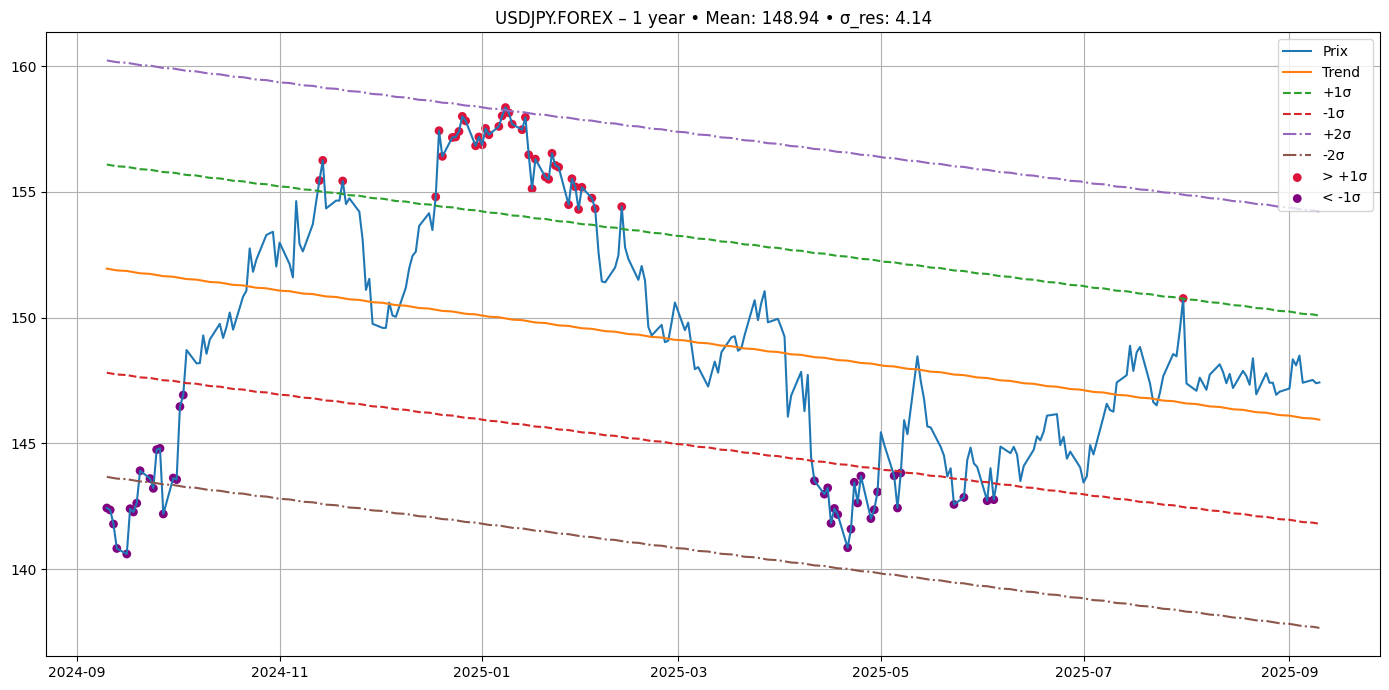

In [246]:
# OUTPUT

api_token = API_TOKEN
ticker = "USDJPY.FOREX"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
logger = Logger.setup()

# data collection and cleaning
data = get_daily_data(ticker, start_1y, end_date, API_TOKEN, logger).copy()
data = clean_data(data)

analysed_data = analysis(data, logger, True)

plot_with_quantification(data, f'{ticker} – 1 year')
